## Importaciones

In [7]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn import metrics
import seaborn as sns
import itertools
import glob
%matplotlib inline
from datetime import datetime
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# Fase 1 - Comprensión del negocio

En esta fase se identificarán los factores clave necesarios para abordar los objetivos empresariales y se plantearán en objetivos específicos de minería de datos, asegurando que el análisis posterior responda adecuadamente a las necesidades del negocio.

# Fase 2 - Comprensión de los datos

Durante esta fase, se realizará una recolección y análisis preliminar de los datos disponibles, con el objetivo de comprender su naturaleza y calidad. Se identificarán patrones iniciales y posibles problemas que puedan afectar el análisis, lo que permitirá guiar el proceso de preparación de los datos.

Se crea el dataset, si no se encuentra en la carpeta "simpsons_data".

In [ ]:
if not os.path.exists("/app/notebooks/Entrega2/simpsons_data/simpsons_dataset"):
    !python /app/notebooks/Entrega2/setup_data.py

Se mapean los personajes que se ocuparán para la exploración y predicción (18 personajes).

In [38]:
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

Se ajustan el tamaño de las imágenes a 64x64 y se ajustan las rutas al dataset de entrenamiento y el dataset de prueba.

In [39]:
IMG_SIZE = 64

DATASET_TRAIN_PATH = "/app/notebooks/Entrega2/simpsons_data/simpsons_dataset"
DATASET_TEST_PATH = "/app/notebooks/Entrega2/simpsons_data/kaggle_simpson_testset/kaggle_simpson_testset"

Se crea la función para cargar los datos de entrenamiento.

In [40]:
def load_train_set(dirname, map_characters, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
            print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

Se crea la función para cargar los datos de prueba.

In [41]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X_test.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

Se cargan las funciones y se guardan los datos en variables.

In [42]:
print("Cargando datos de entrenamiento...")
X, y = load_train_set(DATASET_TRAIN_PATH, MAP_CHARACTERS)

print("Cargando datos de test...")
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_CHARACTERS)

Cargando datos de entrenamiento...
Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1352 imágenes encontradas de bart_simpson
Leyendo 1203 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2256 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1216 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1089 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Cargando datos de t

Se mezclan aleatoriamente los datos de entrenamiento.

In [43]:
print("Barajando datos...")
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

Barajando datos...


Se visualiza información importante de los datasets, como la cantidad de datos, el tamaño de las imágenes y la cantidad de las clases.

In [44]:
print(f"\nInformación del dataset:")
print(f"- Datos de entrenamiento: {X.shape} imágenes, {len(np.unique(y))} clases")
print(f"- Datos de test: {X_t.shape} imágenes, {len(np.unique(y_t))} clases")


Información del dataset:
- Datos de entrenamiento: (19042, 64, 64, 3) imágenes, 18 clases
- Datos de test: (890, 64, 64, 3) imágenes, 18 clases


Se visualizan ejemplos de los datos distribuidos en el conjunto de prueba y entrenamiento.

In [45]:
print("\nDistribución de clases (primeras 5):")
for i in range(5):
    char_name = MAP_CHARACTERS[i]
    train_count = np.sum(y == i)
    test_count = np.sum(y_t == i)
    print(f"- {char_name}: {train_count} imágenes de entrenamiento, {test_count} imágenes de test")


Distribución de clases (primeras 5):
- abraham_grampa_simpson: 913 imágenes de entrenamiento, 48 imágenes de test
- apu_nahasapeemapetilon: 623 imágenes de entrenamiento, 50 imágenes de test
- bart_simpson: 1352 imágenes de entrenamiento, 50 imágenes de test
- charles_montgomery_burns: 1203 imágenes de entrenamiento, 48 imágenes de test
- chief_wiggum: 986 imágenes de entrenamiento, 50 imágenes de test


**Pasar a [Normalización de las imágenes][Fase 3]**

## Separación de datos de entrenamiento y exploración

Separación de los datos de entrenamiento y los de validación

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

Se visualizan la cantidad de datos para el entrenamiento, la validación y la prueba.

In [48]:
print(f"Después de normalización y división:")
print(f"- X_train: {X_train.shape}, valores en rango [{X_train.min():.1f}-{X_train.max():.1f}]")
print(f"- X_val: {X_val.shape}")
print(f"- X_test: {X_t_normalized.shape}")

Después de normalización y división:
- X_train: (15233, 64, 64, 3), valores en rango [0.0-1.0]
- X_val: (3809, 64, 64, 3)
- X_test: (890, 64, 64, 3)


Se crea una función para mostrar ejemplos de las imágenes y de que personaje pertenecen.

In [49]:
def plot_examples(X, y, num_examples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X[i])
        plt.title(MAP_CHARACTERS[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Se ejecuta la función para explorar el conjunto de datos.

Ejemplos de abraham_grampa_simpson:


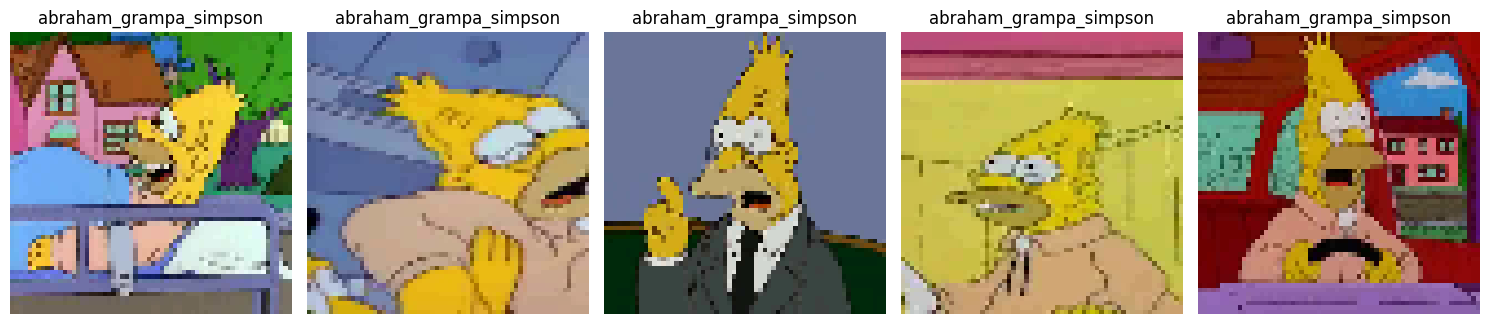

Ejemplos de apu_nahasapeemapetilon:


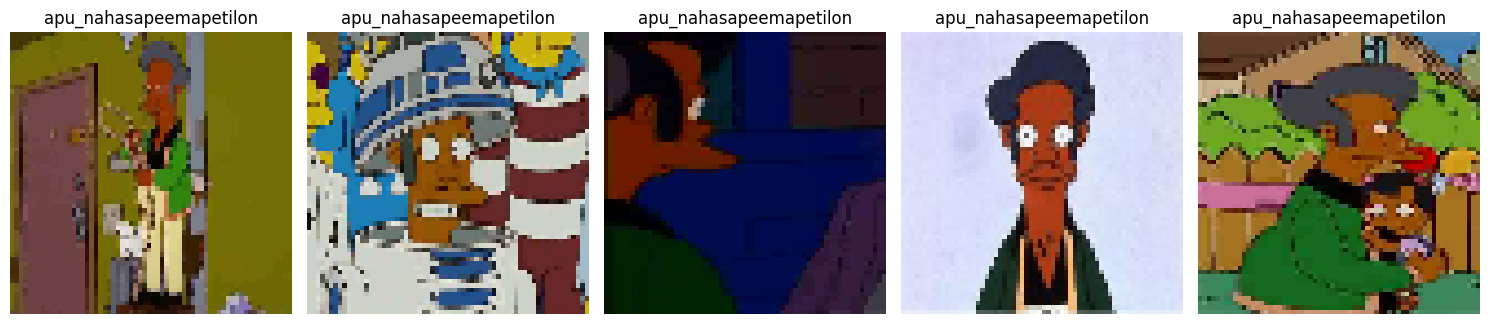

Ejemplos de bart_simpson:


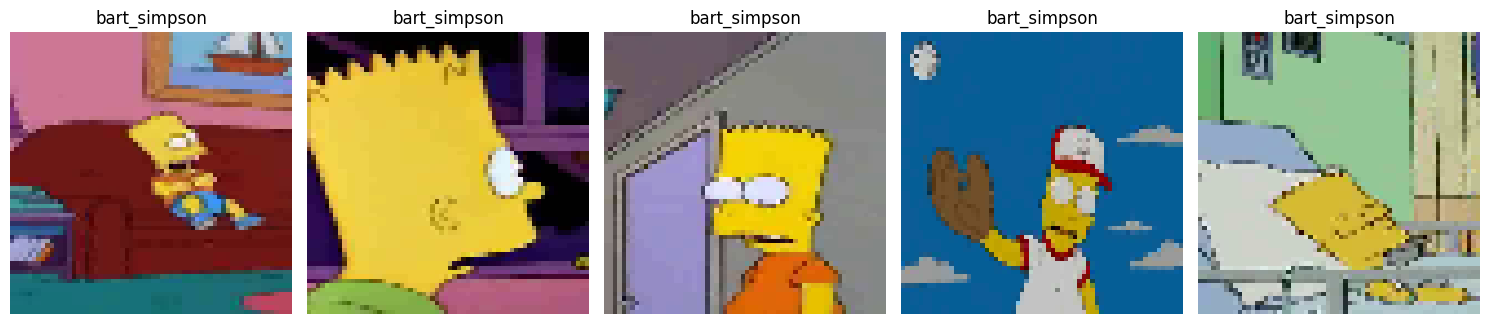

Ejemplos de charles_montgomery_burns:


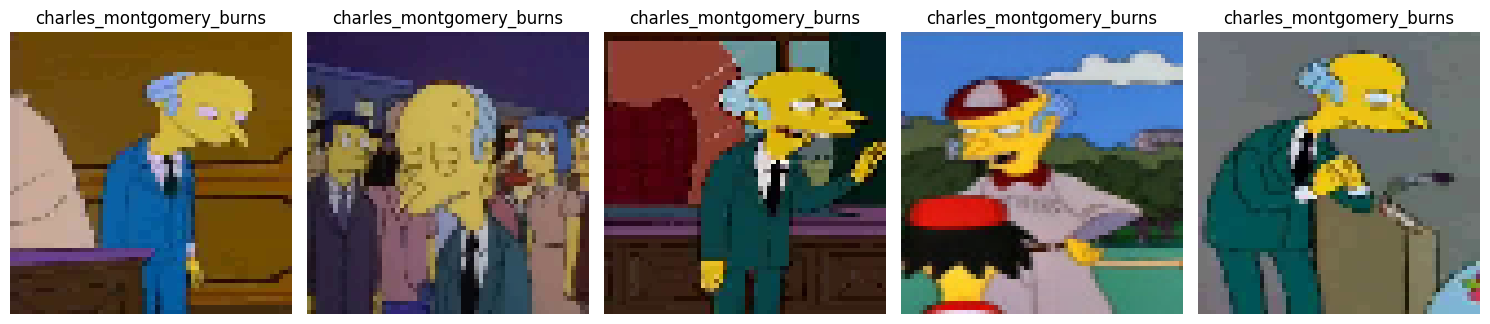

Ejemplos de chief_wiggum:


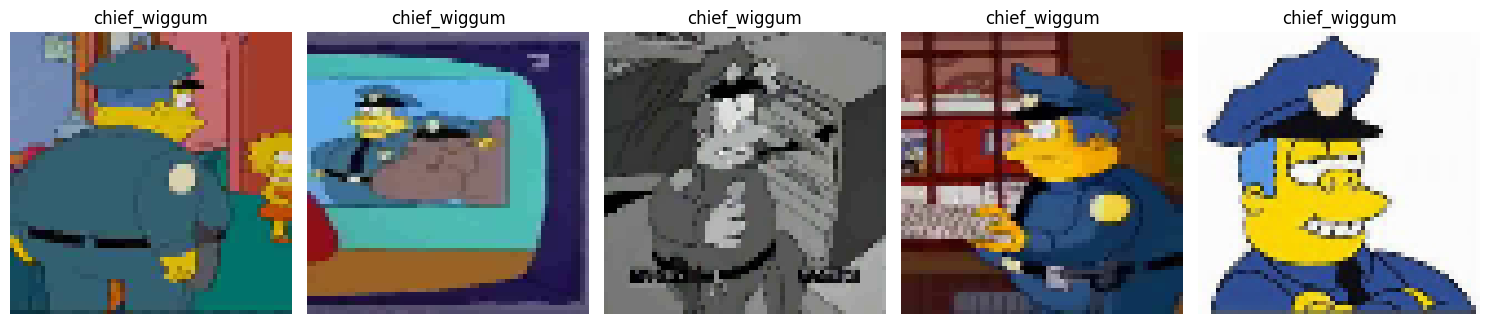

In [50]:
for class_id in range(5):
    examples = X_normalized[y == class_id][:5]
    labels = np.array([class_id] * 5)
    print(f"Ejemplos de {MAP_CHARACTERS[class_id]}:")
    plot_examples(examples, labels)

**Pasar a [Creación del modelo CNN][Fase 4]**

# Fase 3 - Preparación de los datos

En esta fase se seleccionarán, limpiarán y transformarán los datos para que sean adecuados al modelado. Se abordarán problemas como valores faltantes, duplicados o inconsistencias, y se construirán nuevas variables cuando sea necesario, con el objetivo de obtener un conjunto de datos listo para aplicar las técnicas de modelado.

## Normalización de las imágenes

Se normalizan las imágenes escalandolas en un rango de 0 a 1.

In [46]:
X_normalized = X.astype('float32') / 255.0
X_t_normalized = X_t.astype('float32') / 255.0

**Pasar a [Separación de datos de entrenamiento y exploración][Fase 2]**

# Fase 4 - Modelado

En esta fase se seleccionarán los algoritmos de modelado más adecuados y se entrenarán los modelos utilizando el conjunto de datos preparado. Se ajustarán los parámetros de los modelos y se evaluarán los resultados preliminares para determinar qué técnicas ofrecen el mejor desempeño para cumplir con los objetivos planteados.

## Creación del modelo CNN

Se crea una función que crea un modelo de redes neuronales CNN.

In [51]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(18, activation='softmax')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

*En este modelo de Convolutional Neural Networks (CNN) tiene de entrada las imágenes en formato RGB de tamaño 64x64, cuenta con 3 capas Conv2D (Capa de convolución 2D) con filtros de 32, 64 y 128, cada una cuenta con MaxPooling2D para reducir la dimensionalidad espacial, cada una cuenta con una funciones de activación reLU. Este modelo cuenta con una capa densa con 512 neuronas, se ocupa un Dropout del 50% para evitar overfitting y con una salida de 18, los cuales son la cantidad de personajes que predice el modelo, este cuenta con una función de activación softmax para la clasificación multiclase.*
*Al momento de compilarlo este cuenta con un optimizador Adam, con tasa de aprendizaje del 0.001 (valor por defecto), cuenta con una función de pérdida sparse_categorical_crossentropy, la cual es adecuada para etiquetas enteras en problemas de multiclase.*

Se crea un nombre único para guardar el mejor modelo, basandonos principalmente en las características del modelo, la fecha y la hora que se ejecutó el modelo.

In [52]:
num_conv_layers = len([layer for layer in model.layers if isinstance(layer, Conv2D)])
num_filters = "_".join([str(layer.filters) for layer in model.layers if isinstance(layer, Conv2D)])
dropout_rate = next((layer.rate for layer in model.layers if isinstance(layer, Dropout)), 0)
optimizer_name = model.optimizer.__class__.__name__
learning_rate = model.optimizer.learning_rate.numpy()

model_name = f"SimpleCNN_{num_conv_layers}conv_{num_filters}filters_{dropout_rate}drop_{optimizer_name}_lr{learning_rate}_{datetime.now().strftime('%d-%m-%Y_%H%M')}"
print(f"Nombre del modelo: {model_name}")

Nombre del modelo: SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_20-05-2025_0741


Se definen las rutas para guardar los modelos y los logs.

In [53]:
checkpoint_dir = "/app/notebooks/Entrega2/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_best.h5")
final_model_path = os.path.join(checkpoint_dir, f"{model_name}_final.h5")
logs_dir = os.path.join(checkpoint_dir, "logs", model_name)

Se definen los callbacks.

In [54]:
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
tensorboard = TensorBoard(
    log_dir=logs_dir,
    histogram_freq=1
)

*Como callbacks tenemos:*
- *ModelCheckpoint: El cual guarda el modelo con mejor precisión de validación automáticamente durante el entrenamiento.*
- *EarlyStopping: El cual detiene el entrenamiento si la precisión de validación no mejora durante 10 épocas consecutivas, evitando el sobreajuste.*
- *TensorBoard: El cual guarda métricas detalladas del entrenamiento para su visualización en TensorBoard*

Se entrena y guarda el modelo.

In [55]:
print(f"Iniciando entrenamiento del modelo '{model_name}'...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]
)

model.save(final_model_path)
print(f"Modelo guardado en: {final_model_path}")

Iniciando entrenamiento del modelo 'SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_20-05-2025_0741'...
Epoch 1/50
238/239 [============================>.] - ETA: 0s - loss: 2.0433 - accuracy: 0.3779
Epoch 1: val_accuracy improved from -inf to 0.46023, saving model to /app/notebooks/Entrega2/checkpoints/SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_20-05-2025_0741_best.h5
239/239 [==============================] - 28s 110ms/step - loss: 2.0432 - accuracy: 0.3779 - val_loss: 1.8738 - val_accuracy: 0.4602
Epoch 2/50
238/239 [============================>.] - ETA: 0s - loss: 1.2518 - accuracy: 0.6236
Epoch 2: val_accuracy improved from 0.46023 to 0.64374, saving model to /app/notebooks/Entrega2/checkpoints/SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_20-05-2025_0741_best.h5
239/239 [==============================] - 24s 94ms/step - loss: 1.2517 - accuracy: 0.6236 - val_loss: 1.2170 - val_accuracy: 0.6437
Epoch 3/50
238

*Este modelo cuenta con 50 épocas, tiene un tamaño de los batch de 64 (Indica que cada 64 imágenes cambia los pesos) y se ocupan los callbacks anteriormente definidos (ModelCheckpoint, EarlyStopping y TensorBoard).*

**Pasar a [Evaluación del modelo CNN][Fase 5]**

# Fase 5 - Evaluación

En la fase de evaluación se analizará el rendimiento de los modelos desarrollados, comparándolos con los objetivos del negocio para asegurar que sean útiles y precisos. Se tomará en cuenta la validez de los resultados, se decidirá si es necesario ajustar los modelos o si están listos para su implementación.

## Evaluación del modelo CNN

Se carga el modelo guardado con anterioridad.

In [56]:
best_model = load_model(checkpoint_path)

Se evalua el modelo con el conjunto de datos de prueba.

In [57]:
test_loss, test_acc = best_model.evaluate(X_t_normalized, y_t)
print(f"Accuracy en el conjunto de test: {test_acc:.4f}")

28/28 [==============================] - 1s 14ms/step - loss: 0.1594 - accuracy: 0.9719
Accuracy en el conjunto de test: 0.9719


### Conclusión basada en el accouracy

El modelo de red neuronal convolucional (CNN) entrenado para clasificar personajes de los simpsons alcanzó un accuracy del 97.19% en el conjunto de prueba, lo que indica un desempeño excelente en la tarea de clasificación multiclase, esta alta precisión sugiere que el modelo generaliza bien sobre datos no vistos, aprendió patrones discriminativos efectivos entre las 18 clases de personajes ocupadas y es apto para aplicaciones prácticas que involucren reconocimiento automático de personajes en imágenes.

### Confusion Matrix, curva de entrenamiento, ejemplos de predicción correcta y errada.

Se hacen las predicciones con el modelo para el análisis.

In [58]:
y_pred = best_model.predict(X_t_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 [==============================] - 0s 12ms/step


Se crea y se ejecuta una confusion matrix, para evaluar la precisión del modelo para los datos de prueba.

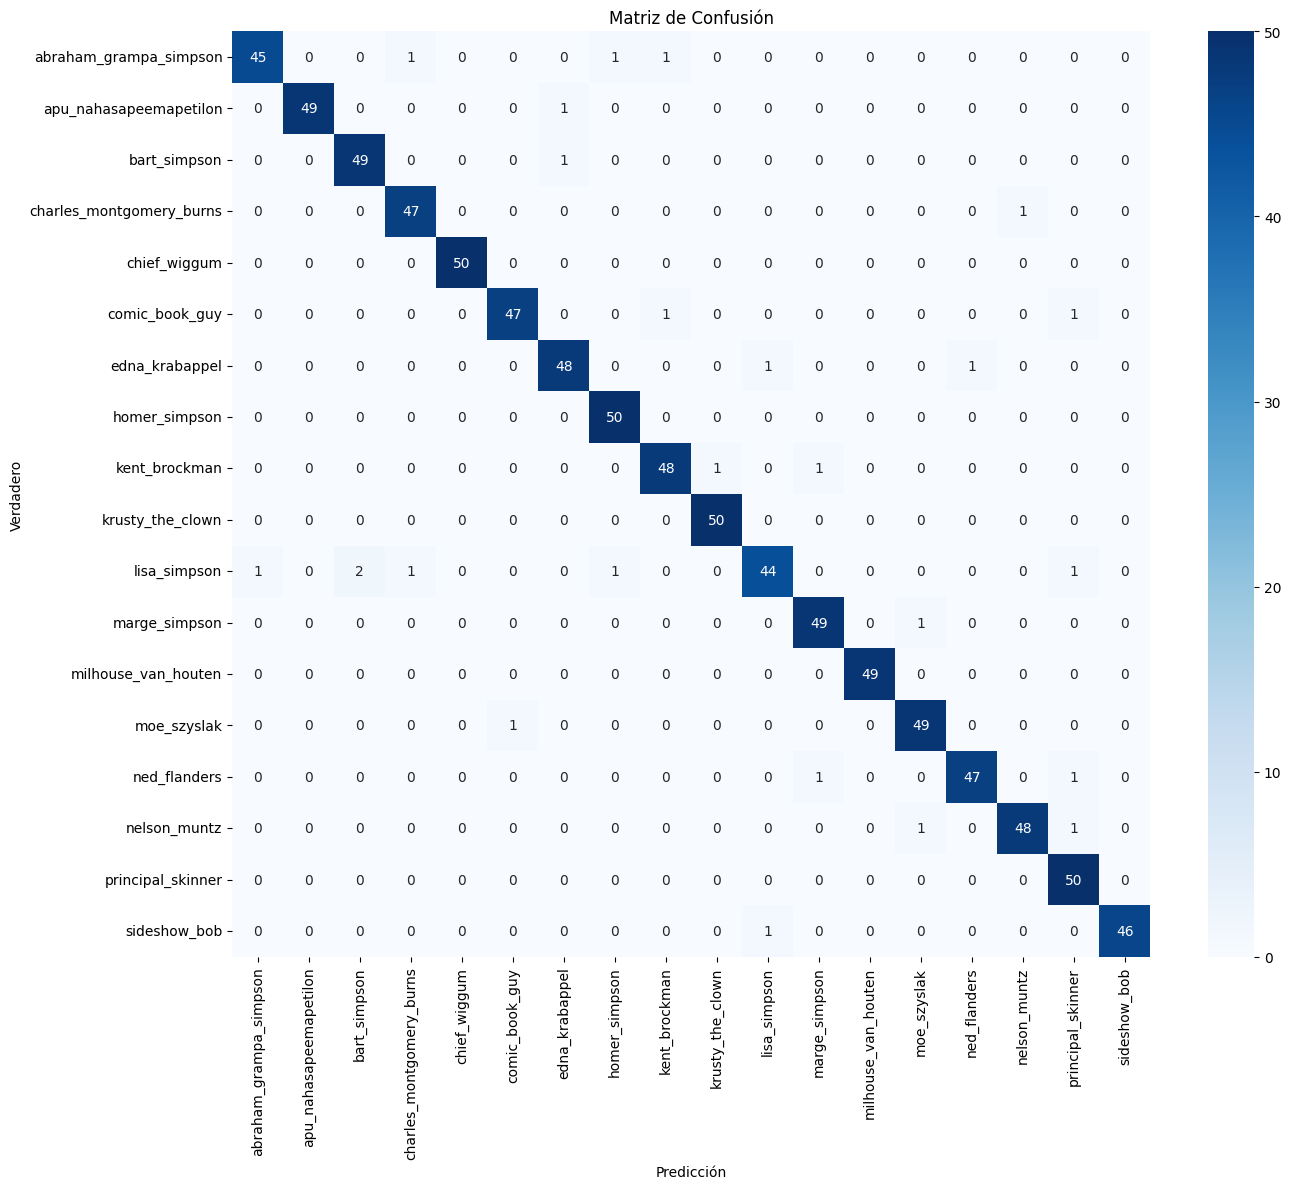

Reporte de clasificación:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.94      0.96        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       0.96      0.98      0.97        50
charles_montgomery_burns       0.96      0.98      0.97        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       0.98      0.96      0.97        49
          edna_krabappel       0.96      0.96      0.96        50
           homer_simpson       0.96      1.00      0.98        50
           kent_brockman       0.96      0.96      0.96        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.96      0.88      0.92        50
           marge_simpson       0.96      0.98      0.97        50
     milhouse_van_houten       1.00      1.00      1.00        49
             moe_szyslak       0.96      0.98    

In [59]:
cm = confusion_matrix(y_t, y_pred_classes)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[MAP_CHARACTERS[i] for i in range(18)],
            yticklabels=[MAP_CHARACTERS[i] for i in range(18)])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Reporte de clasificación:")
print(classification_report(
    y_t, y_pred_classes,
    target_names=[MAP_CHARACTERS[i] for i in range(18)]
))

Se ejemplifican las predicciones del dataset de prueba, mostrando imágenes que predijo correctamente y las que no.

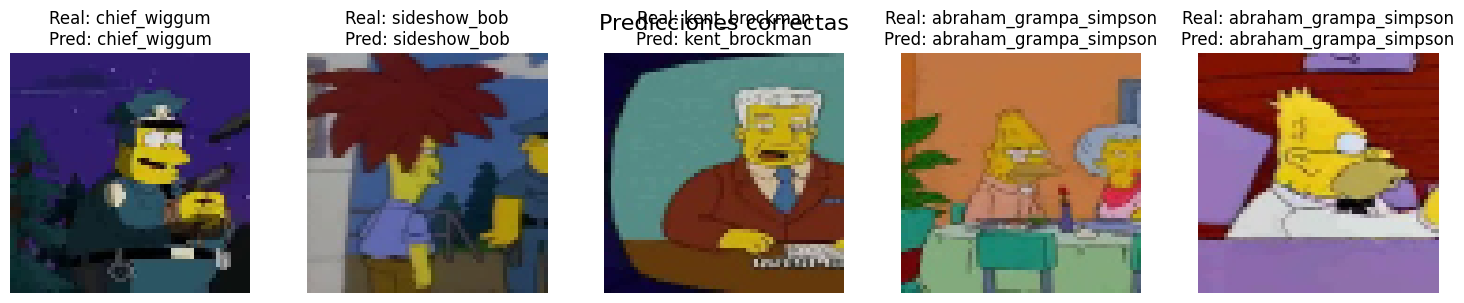

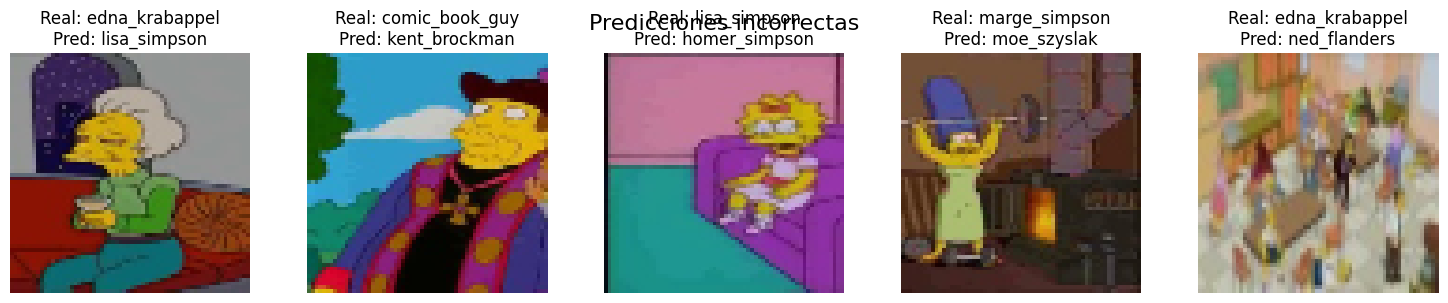

In [62]:
def plot_predictions(X, y_true, y_pred, num_examples=5, correct=True):
    if correct:
        indices = np.where(y_true == y_pred)[0]
        title = "Predicciones correctas"
    else:
        indices = np.where(y_true != y_pred)[0]
        title = "Predicciones incorrectas"
    
    if len(indices) > num_examples:
        selected = np.random.choice(indices, num_examples, replace=False)
    else:
        selected = indices
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    
    for i, idx in enumerate(selected):
        plt.subplot(1, len(selected), i+1)
        plt.imshow(X_t_normalized[idx])
        plt.title(f"Real: {MAP_CHARACTERS[y_t[idx]]}\nPred: {MAP_CHARACTERS[y_pred_classes[idx]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_predictions(X_t_normalized, y_t, y_pred_classes, correct=True)
plot_predictions(X_t_normalized, y_t, y_pred_classes, correct=False)

Curva de entrenamiento del modelo.

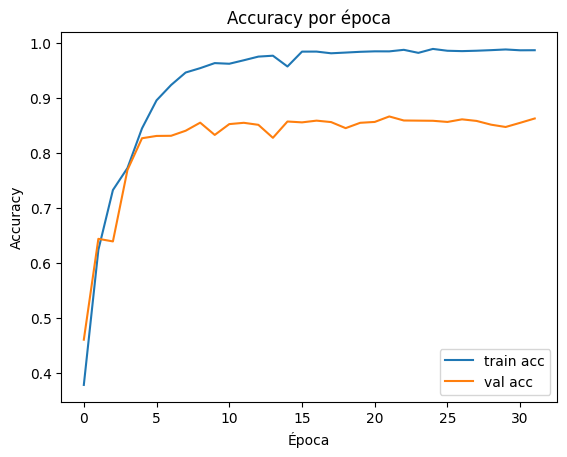

In [63]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Fase 6 - Implementación

En esta fase los modelos serán implementados en un entorno productivo para su uso real. Se generarán reportes detallados sobre los resultados y se establecerá un plan de mantenimiento y actualización periódica para asegurar la continua eficacia del modelo en el tiempo.